#Evaluate Model 2 PSG-Audio
This version modified to be a bit more stand-alone (downloads files using gdown).




Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2023



<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* 

# Imports

In [1]:
import os
import shutil
import time
from datetime import datetime
from datetime import date
from datetime import timedelta # for calculating training time
from random import randrange # for plotting samples
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tabulate import tabulate # for verbose tables, showing data
import tensorflow as tf
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import compute_sample_weight
import sys
import urllib.request # to get files from web w/o !wget
from shutil import unpack_archive # to unzip

In [2]:
my_dir = '.' # replace with absolute path if desired
interactive = True # runs simple calls for most cells
# verbose = True

working_dir = os.path.join(my_dir,'psg_dataset') # create local directory
if not os.path.exists(working_dir):
    os.mkdir(working_dir)

# Get small or full processed PSG-Audio numpy arrays
See PSG-Audio_load_dataset_for_multi-output.ipynb for info, this is source of the arrays.


In [3]:
use_small = True # arrays are 1/10th the size for shorter download/train time
if use_small:
    version = "small"
    flist = ["small_x_train.npy", "small_y_train.npy", "small_sub_train.npy"]
else:
    version = "full"
    flist = ["x_train.npy", "y_train.npy", "sub_train.npy"]

In [4]:
# this needs to be per file apparently.
# !gdown.download_folder('https://drive.google.com/drive/folders/10G5SbdPKZWpZSBkO_II8dR4SoOfEJJwz?usp=sharing')

!gdown "1zo_Amyb_vbAL1VKpa1IKtuHpL5Gw9IaG&confirm=t" # small_x_train
!gdown "1_ZFknIBTNaCS7lCILDM0loUOFUUzz8EZ&confirm=t" # small_y_train
!gdown "1KbOqMdPlOUaT1TQMY_NTp-oKqnRzelfb&confirm=t" # small_sub_train
working_dir = "." # just to stay compatible, gdown uses current dir.

Downloading...
From: https://drive.google.com/uc?id=1zo_Amyb_vbAL1VKpa1IKtuHpL5Gw9IaG&confirm=t
To: /content/small_x_train.npy
100% 610M/610M [00:04<00:00, 125MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ZFknIBTNaCS7lCILDM0loUOFUUzz8EZ&confirm=t
To: /content/small_y_train.npy
100% 84.8k/84.8k [00:00<00:00, 63.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KbOqMdPlOUaT1TQMY_NTp-oKqnRzelfb&confirm=t
To: /content/small_sub_train.npy
100% 84.8k/84.8k [00:00<00:00, 61.8MB/s]


In [30]:
def read_arrays():
    """read in the arrays - leaving test arrays out of this for now (just tuning model)"""
    if use_small:
        print("Reading in small arrays")
        X = np.load(os.path.join(working_dir, 'small_x_train.npy'))
        y = np.load(os.path.join(working_dir, 'small_y_train.npy'))
        sub = np.load(os.path.join(working_dir, 'small_sub_train.npy'))
    else:
        print("Reading in full arrays")
        X = np.load(os.path.join(working_dir, 'x_train.npy'))
        y = np.load(os.path.join(working_dir, 'y_train.npy'))
        sub = np.load(os.path.join(working_dir, 'sub_train.npy'))
    print("Reading arrays from npy files")
    headers = ("Array","shape", "data type")
    mydata = [("X:", X.shape, X.dtype),
            ("y:", y.shape, y.dtype),
            ("sub:", sub.shape, sub.dtype)]
    print("\n",tabulate(mydata, headers=headers))
    return X, y, sub
if interactive:
    X, y, sub = read_arrays()

Reading in small arrays
Reading arrays from npy files

 Array    shape             data type
-------  ----------------  -----------
X:       (42333, 300, 12)  float32
y:       (42333, 2)        int8
sub:     (42333, 1)        uint16


# Split X by Signal Modality and y by Event Type

In [31]:
X_eeg = X[:,:,0:3] # first 3 channels (0,1,2)
X_eog = X[:,:,3:5] # channels 3 and 4
X_emg = X[:,:,5:6] # just channel 5
X_ecg = X[:,:,8:9] # ECG - this is a goofy way to keep shape w/ one channel...
X_flow = X[:,:,9:10] # ECG - this is a goofy way to keep shape w/ one channel...
X_resp = X[:,:,10:12] # abd, thor

y_card = y[:,0:1]
y_resp = y[:,1:2]

temp = [X_eeg, X_eog, X_emg, X_ecg, X_flow,
            X_resp,y_card, y_resp]
for item in temp:
    print(item.shape)

(42333, 300, 3)
(42333, 300, 2)
(42333, 300, 1)
(42333, 300, 1)
(42333, 300, 1)
(42333, 300, 2)
(42333, 1)
(42333, 1)


In [32]:
unique, counts = np.unique(y_card, return_counts=True)
print("\ny_card label values and counts:\n",str(np.asarray((unique, counts)).T))
class_names_y_card = ['Normal','Abnormal'] # matches _90_10 processed files

unique, counts = np.unique(y_resp, return_counts=True)
print("\ny_resp label values and counts:\n",str(np.asarray((unique, counts)).T))
class_names_y_resp = ['Normal','Apnea','Hypopnea'] # matches _90_10 processed files


y_card label values and counts:
 [[    0 37157]
 [    1  5176]]

y_resp label values and counts:
 [[    0 23252]
 [    1 15479]
 [    2  3602]]


In [8]:
# compute class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced'
                                               ,classes = np.unique(y_card)
                                               ,y = y_card[:,0])
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.5696504023467988, 1: 4.089354714064915}


In [33]:
sample_weights = compute_sample_weight('balanced', y_card)
print("sample_weights",sample_weights)
print("sample_weights length",len(sample_weights))
unique, counts = np.unique(sample_weights, return_counts=True)
print("sample_weights values and counts:\n",str(np.asarray((unique, counts)).T))




sample_weights [0.5696504 0.5696504 0.5696504 ... 0.5696504 0.5696504 0.5696504]
sample_weights length 42333
sample_weights values and counts:
 [[5.69650402e-01 3.71570000e+04]
 [4.08935471e+00 5.17600000e+03]]


In [11]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
# ref for functional model https://keras.io/guides/functional_api/

# keeping all inputs for re-useability - model will decide which to use
def build_model(x_train_eeg, x_train_eog, x_train_emg, x_train_ecg, x_train_flow,
                x_train_resp, y_train_card):
    n_outputs = y_train_card.shape[1] # how to handle both outputs?
    # input layers - 1st dim is timesteps, 2nd is features
    eeg_input = keras.Input(shape = (x_train_eeg.shape[1], x_train_eeg.shape[2]), name = "eeg")
    eog_input = keras.Input(shape = (x_train_eog.shape[1], x_train_eog.shape[2]), name = "eog")
    emg_input = keras.Input(shape = (x_train_emg.shape[1], x_train_emg.shape[2]), name = "emg")
    ecg_input = keras.Input(shape = (x_train_ecg.shape[1], x_train_ecg.shape[2]), name = "ecg")
    flow_input = keras.Input(shape = (x_train_flow.shape[1], x_train_flow.shape[2]), name = "flow")
    resp_input = keras.Input(shape = (x_train_resp.shape[1], x_train_resp.shape[2]), name = "resp")

    a = layers.Conv1D(filters=50, kernel_size=17, activation='relu')(eog_input)
    a = layers.SpatialDropout1D(0.25)(a)
    a = layers.Conv1D(filters=50, kernel_size=17, activation='relu')(a)
    a = layers.MaxPooling1D(pool_size=12)(a)
    a = layers.Dropout(0.25)(a)

    b = layers.Conv1D(filters=50, kernel_size=33, activation='relu')(ecg_input)
    b = layers.SpatialDropout1D(0.25)(b)
    b = layers.Conv1D(filters=50, kernel_size=33, activation='relu')(b)
    b = layers.MaxPooling1D(pool_size=12)(b)
    b = layers.Dropout(0.25)(b)

    merged = layers.Concatenate(axis=1)([a, b]) 
    merged = layers.GlobalAveragePooling1D()(merged)
    pred = layers.Dense(n_outputs, activation='softmax', name='act_pred')(merged)

    model = keras.Model(
        inputs=[eeg_input, eog_input, emg_input, ecg_input, flow_input, resp_input],
        outputs=[pred],
    )
    return model
# if interactive:
#     my_model = build_model(X_eeg, X_eog, X_emg, X_ecg, X_flow,
#                 X_resp, y_card)
#     # model.summary()
#     display(keras.utils.plot_model(my_model, "my_model.png", show_shapes=True))


# Note I put the number of epochs way down to test the output and cross valid.

In [36]:
def train_model(model, 
                x_train_eeg, x_train_eog, x_train_emg, x_train_ecg,
                x_train_flow, x_train_resp, y_train_card,
                x_test_eeg, x_test_eog, x_test_emg, x_test_ecg, 
                x_test_flow, x_test_resp, y_test_card,
                BATCH_SIZE = 128,    # Typical values are 8, 16 or 32
                NUM_EPOCHS = 30): # Max number run unless earlystopping callback fires
    # channels = [x_train_eeg, x_train_eog, x_train_emg, x_train_ecg, 
    #             x_train_flow, x_train_resp, y_train_card, 
    #             x_test_eeg, x_test_eog, x_test_emg, x_test_ecg, 
    #             x_test_flow, x_test_resp, y_test_card]
    # for item in channels:
    #     print(item.shape)
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=10)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    sample_weights = compute_sample_weight('balanced', y_train_card)
    sample_weights = np.sqrt(sample_weights) # no idea why weights are squared.
    print("sample_weights",sample_weights)
    print("sample_weights length",len(sample_weights))
    unique, counts = np.unique(sample_weights, return_counts=True)
    print("sample_weights values and counts:\n",str(np.asarray((unique, counts)).T))

    history = model.fit(
        #{"acc": x_train_acc, "bvp": x_train_bvp, "eda": x_train_eda,"ptemp": x_train_ptemp},
        #{"act_pred": y_train},
        {"eeg": x_train_eeg, "eog": x_train_eog, "emg": x_train_emg,"ecg": x_train_ecg,
         "flow": x_train_flow, "resp":x_train_resp},
         {"act_pred": y_train_card},
         #{"y_card":y_train_card, "y_resp":y_train_resp},
        epochs=NUM_EPOCHS,
        callbacks=[callback],
        #class_weight = class_weights, ### this line fails
        sample_weight=sample_weights,
        validation_data=({"eeg": x_test_eeg, "eog": x_test_eog, "emg": x_test_emg,"ecg": x_test_ecg,
                          "flow": x_test_flow, "resp":x_test_resp}, {"act_pred":y_test_card}),
                         
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history, model

# if (interactive):
#     # Note:  if you rerun this cell it continues to train the existing model
#     history, model = train_4input_CNN_no_val(model, x_train_acc, x_train_bvp,
#                                       x_train_eda, x_train_ptemp ,y_train,NUM_EPOCHS = 100)
#     #show final training loss
#     print("4 x 1D CNN Functional Model")
#     plt.plot(history.history["loss"], label="Training Loss")
#     plt.ylim([0,2.5]) #set limit - 1.2 has been a good value experimentally
#     plt.legend()
#     plt.show()

## Run a stratified 5-fold group-based cross validation

Fold 0:
sample_weights [0.56047618 0.56047618 0.56047618 ... 0.56047618 0.56047618 0.56047618]
sample_weights length 34652
sample_weights values and counts:
 [[5.60476175e-01 3.09130000e+04]
 [4.63385932e+00 3.73900000e+03]]
Epoch 1/30
1083/1083 [==============================] - 9s 7ms/step - loss: 1.5945 - accuracy: 0.5803 - val_loss: 0.6457 - val_accuracy: 0.6205
Epoch 2/30
1083/1083 [==============================] - 8s 7ms/step - loss: 0.6265 - accuracy: 0.6240 - val_loss: 0.7559 - val_accuracy: 0.5157
Epoch 3/30
1083/1083 [==============================] - 8s 7ms/step - loss: 0.6075 - accuracy: 0.6653 - val_loss: 0.6948 - val_accuracy: 0.6107
Epoch 4/30
1083/1083 [==============================] - 7s 7ms/step - loss: 0.5973 - accuracy: 0.6955 - val_loss: 0.7780 - val_accuracy: 0.5610
Epoch 5/30
1083/1083 [==============================] - 8s 7ms/step - loss: 0.6132 - accuracy: 0.7001 - val_loss: 0.6830 - val_accuracy: 0.7108
Epoch 6/30
1083/1083 [==============================] -

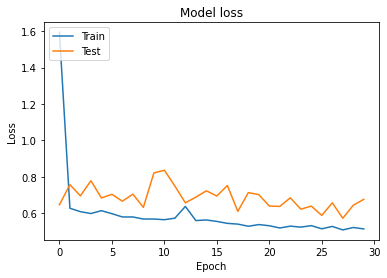

Fold 1:
sample_weights [0.5766339 0.5766339 0.5766339 ... 0.5766339 0.5766339 0.5766339]
sample_weights length 33439
sample_weights values and counts:
 [[5.76633902e-01 2.89950000e+04]
 [3.76226373e+00 4.44400000e+03]]
Epoch 1/30
1045/1045 [==============================] - 9s 8ms/step - loss: 0.8912 - accuracy: 0.6453 - val_loss: 0.5756 - val_accuracy: 0.7289
Epoch 2/30
1045/1045 [==============================] - 7s 7ms/step - loss: 0.5887 - accuracy: 0.7267 - val_loss: 0.6395 - val_accuracy: 0.6747
Epoch 3/30
1045/1045 [==============================] - 7s 7ms/step - loss: 0.5753 - accuracy: 0.7472 - val_loss: 0.6303 - val_accuracy: 0.6766
Epoch 4/30
1045/1045 [==============================] - 8s 7ms/step - loss: 0.5786 - accuracy: 0.7439 - val_loss: 0.5967 - val_accuracy: 0.6965
Epoch 5/30
1045/1045 [==============================] - 8s 7ms/step - loss: 0.5589 - accuracy: 0.7555 - val_loss: 0.5753 - val_accuracy: 0.7037
Epoch 6/30
1045/1045 [==============================] - 7s 7m

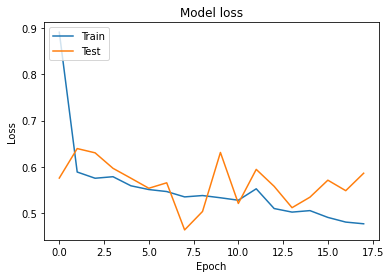

Fold 2:
sample_weights [0.57773786 0.57773786 0.57773786 ... 0.57773786 0.57773786 0.57773786]
sample_weights length 34090
sample_weights values and counts:
 [[5.77737857e-01 2.95030000e+04]
 [3.71593634e+00 4.58700000e+03]]
Epoch 1/30
1066/1066 [==============================] - 9s 8ms/step - loss: 0.9685 - accuracy: 0.6510 - val_loss: 0.7920 - val_accuracy: 0.5555
Epoch 2/30
1066/1066 [==============================] - 7s 7ms/step - loss: 0.5804 - accuracy: 0.7210 - val_loss: 0.6987 - val_accuracy: 0.7222
Epoch 3/30
1066/1066 [==============================] - 7s 7ms/step - loss: 0.5644 - accuracy: 0.7263 - val_loss: 0.7472 - val_accuracy: 0.6597
Epoch 4/30
1066/1066 [==============================] - 7s 7ms/step - loss: 0.5533 - accuracy: 0.7424 - val_loss: 0.5993 - val_accuracy: 0.6938
Epoch 5/30
1066/1066 [==============================] - 8s 7ms/step - loss: 0.5589 - accuracy: 0.7427 - val_loss: 0.6488 - val_accuracy: 0.7519
Epoch 6/30
1066/1066 [==============================] -

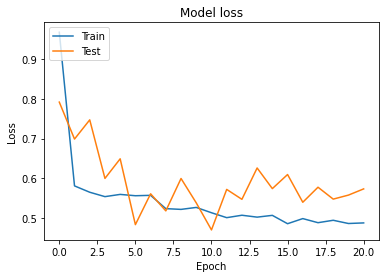

Fold 3:
sample_weights [0.55913909 0.55913909 0.55913909 ... 0.55913909 0.55913909 0.55913909]
sample_weights length 34396
sample_weights values and counts:
 [[5.59139086e-01 3.07580000e+04]
 [4.72732270e+00 3.63800000e+03]]
Epoch 1/30
1075/1075 [==============================] - 9s 8ms/step - loss: 0.9512 - accuracy: 0.5673 - val_loss: 0.6113 - val_accuracy: 0.7427
Epoch 2/30
1075/1075 [==============================] - 7s 7ms/step - loss: 0.6387 - accuracy: 0.7151 - val_loss: 0.6335 - val_accuracy: 0.7161
Epoch 3/30
1075/1075 [==============================] - 7s 7ms/step - loss: 0.6106 - accuracy: 0.7272 - val_loss: 0.5975 - val_accuracy: 0.7514
Epoch 4/30
1075/1075 [==============================] - 7s 7ms/step - loss: 0.5915 - accuracy: 0.7511 - val_loss: 0.6302 - val_accuracy: 0.7449
Epoch 5/30
1075/1075 [==============================] - 8s 7ms/step - loss: 0.5999 - accuracy: 0.7416 - val_loss: 0.6696 - val_accuracy: 0.7175
Epoch 6/30
1075/1075 [==============================] -

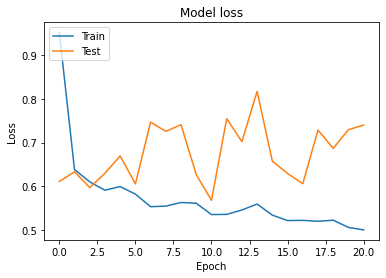

Fold 4:
sample_weights [0.575477 0.575477 0.575477 ... 0.575477 0.575477 0.575477]
sample_weights length 32755
sample_weights values and counts:
 [[5.75477002e-01 2.84590000e+04]
 [3.81226723e+00 4.29600000e+03]]
Epoch 1/30
1024/1024 [==============================] - 9s 8ms/step - loss: 0.8912 - accuracy: 0.6513 - val_loss: 0.7071 - val_accuracy: 0.5702
Epoch 2/30
1024/1024 [==============================] - 7s 7ms/step - loss: 0.5994 - accuracy: 0.7236 - val_loss: 0.6559 - val_accuracy: 0.6287
Epoch 3/30
1024/1024 [==============================] - 7s 7ms/step - loss: 0.5819 - accuracy: 0.7525 - val_loss: 0.5117 - val_accuracy: 0.8056
Epoch 4/30
1024/1024 [==============================] - 8s 7ms/step - loss: 0.5713 - accuracy: 0.7569 - val_loss: 0.7110 - val_accuracy: 0.7058
Epoch 5/30
1024/1024 [==============================] - 7s 7ms/step - loss: 0.5526 - accuracy: 0.7786 - val_loss: 0.6758 - val_accuracy: 0.6127
Epoch 6/30
1024/1024 [==============================] - 8s 7ms/step

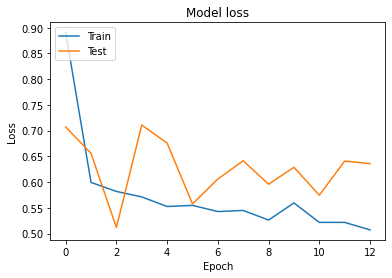

------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 0.68 - Accuracy: 64.07%
> Fold 2 - Loss: 0.59 - Accuracy: 72.90%
> Fold 3 - Loss: 0.57 - Accuracy: 71.36%
> Fold 4 - Loss: 0.74 - Accuracy: 70.86%
> Fold 5 - Loss: 0.64 - Accuracy: 75.62%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 70.96 (+- 3.826)
------------------------------------------------------------------------
Total Training time = 0:14:23 HH:MM:SS
> Accuracy: 70.96 (+- 3.826)


In [37]:
def run_cross_val():
    """runs a five fold cross-validation pass. returns accuracy string"""
    #print ("running model",my_model.description)

    # Define per-fold score containers
    acc_per_fold = []
    loss_per_fold = []
    y_pred_per_fold = []
    y_test_per_fold = []

    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

    start_time = time.time()

    for i, (train_index, test_index) in enumerate(skf.split(X, y[:,0], groups=sub)):
        print(f"Fold {i}:")

        # x_train, y_train = X[train_index], y[train_index]
        # x_test, y_test = X[test_index], y[test_index]
        x_train_eeg, x_train_eog, x_train_emg, x_train_ecg, x_train_flow,x_train_resp \
            = X_eeg[train_index], X_eog[train_index], X_emg[train_index], X_ecg[train_index], X_flow[train_index], X_resp[train_index]
        y_train_card, y_train_resp = y_card[train_index], y_resp[train_index]

        x_test_eeg, x_test_eog, x_test_emg, x_test_ecg, x_test_flow,x_test_resp \
            = X_eeg[test_index], X_eog[test_index], X_emg[test_index], X_ecg[test_index], X_flow[test_index], X_resp[test_index]
        y_test_card, y_test_resp = y_card[test_index], y_resp[test_index]
        # One Hot Encode: Note for respiratory there are 5 relatively frequent
        # categories but others can appear in only a portion of the folds.

        enc = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
        y_train_card = enc.fit_transform(y_train_card)
        y_test_card = enc.transform(y_test_card)

        y_train_resp = enc.fit_transform(y_train_resp)
        y_test_resp = enc.transform(y_test_resp)

        model = build_model(x_train_eeg, x_train_eog, x_train_emg, x_train_ecg,
                            x_train_flow, x_train_resp, y_train_card)
        history, model = train_model(model, 
                                     x_train_eeg, x_train_eog, x_train_emg, x_train_ecg,
                                     x_train_flow, x_train_resp, y_train_card,
                                     x_test_eeg, x_test_eog, x_test_emg, x_test_ecg,
                                     x_test_flow, x_test_resp, y_test_card)  
        val_acc = history.history['val_accuracy'][-1]
        val_loss = history.history['val_loss'][-1] 

        acc_per_fold.append(val_acc * 100)
        loss_per_fold.append(val_loss)

        # Generate predictions
        y_pred = model.predict([x_test_eeg, x_test_eog, x_test_emg, x_test_ecg,
                               x_test_flow, x_test_resp])

        y_pred = np.argmax(y_pred, axis=1)
        y_pred_per_fold.append(y_pred)
        y_test_per_fold.append(np.argmax(y_test_card, axis=1))

        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
    #     print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]:4.2} - Accuracy: {acc_per_fold[i]:4.2f}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold):4.2f} (+- {np.std(acc_per_fold):5.4})')
    acc_str = temp = str(f'> Accuracy: {np.mean(acc_per_fold):4.2f} (+- {np.std(acc_per_fold):5.4})')
    print('------------------------------------------------------------------------')

    # Show total training time
    end_time = time.time()
    train_time = timedelta(seconds=(end_time - start_time))
    print('Total Training time =',(str(train_time).split(".")[0]), 'HH:MM:SS')
    # to plot confusion matrices return concat versions of y
    y_pred = np.concatenate(y_pred_per_fold)
    y_test = np.concatenate(y_test_per_fold)
    return acc_str, y_pred, y_test
result, y_pred, y_test = run_cross_val()
#print ("running model",my_model.description)
print(result)

              precision    recall  f1-score   support

           0       0.89      0.76      0.82     37157
           1       0.17      0.35      0.23      5176

    accuracy                           0.71     42333
   macro avg       0.53      0.56      0.53     42333
weighted avg       0.81      0.71      0.75     42333

Normalized confusion matrix
[[0.76 0.24]
 [0.65 0.35]]


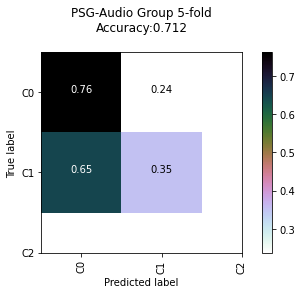

In [38]:
# == Confusion matrix ==
from sklearn.metrics import confusion_matrix
import itertools

#moved to evaluate function
#y_pred = np.concatenate(y_pred_per_fold)
#y_test = np.concatenate(y_test_per_fold)

# print(classification_report(y_test, y_pred, target_names=class_names))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                            normalize=True,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
            print(np.array(cm).round(2)) # to limit digits
        else:
            print('Confusion matrix, without normalization')
            print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes,rotation=90)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
title = 'PSG-Audio Group 5-fold\n'
#title += "Predicting " + labels + " using " + ch_group + '\n'
title += 'Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred))+'\n'
class_names = ['C0','C1','C2'] # placeholder for now
plot_confusion_matrix(cm, classes=class_names, title=title, cmap='cubehelix_r')

# STOP - the following code is to load the data from and save figures to google drive.
You are welcome to use it, but it is untested outside of my environment.

In [ ]:
def get_load_data_utils():
    """checks for local file, if none downloads from IMICS repository.
    Assumes a global my_dir has been defined (default is my_dir = ".")
    :return: nothing"""
    fname = 'load_data_utils.py'
    ffname = os.path.join(my_dir,fname)
    if (os.path.exists(ffname)):
        print ("Local load_data_utils.py found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve("https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py", filename=fname)
if interactive:
    get_load_data_utils()

In [ ]:
from load_data_utils import get_env_info
from load_data_utils import get_log_ffname
from load_data_utils import tabulate_numpy_arrays
from load_data_utils import channel_powerset
if interactive:
    print('My env_info: \n' + get_env_info())

My env_info: 
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
GPU: name, driver_version, memory.total [MiB]
Tesla T4, 510.47.03, 15360 MiB



In [ ]:
save_log = False # set to False to avoid a problem if accidentally run...
# alternate confusion matrix with fig object to save
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                    index = class_names, 
                    columns = class_names)
fig = plt.figure(figsize=(6.5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
#plt.title('Insert title here\n
#plt.title('Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.title('Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()
if save_log:
    log_ffname = get_log_ffname(
    log_file_dir = '/content/drive/My Drive/Colab_Run_Results',
    base_fname = "PSG_Multi_Output_Work")
    print("Saving results to", log_ffname)
    with open(log_ffname, "a") as file_object:
        file_object.write("Generated by Evaluate_Model_PSG-Audio.ipynb\n")
        file_object.write("Processed PSG with 5 fold via sklearn GroupKFold\n")
        file_object.write("Final Accuracy: %0.3f\n" %accuracy_score(y_test, y_pred))
        file_object.write("Classification Report\n")
        file_object.write(classification_report(y_test, y_pred, target_names=class_names))
        file_object.write("Confusion Matrix\n")
        file_object.write(str(cm))
    cm_ffname = log_ffname.split('.')[0] + '_cm.pdf'
    print("saving cm plot as",cm_ffname)
    fig.savefig(cm_ffname,format='pdf', dpi=1200)
    full_model_fname = log_ffname.split('.')[0] + '_model.txt'
    with open(full_model_fname, "a") as file_object:
        model.summary(print_fn=lambda x: file_object.write(x + '\n'))
        #acknowledgement https://stackoverflow.com/users/14951382/sparklingdew
    #plot using keras function
    #ref https://keras.io/api/utils/model_plotting_utils/
    full_mplot_fname = log_ffname.split('.')[0] + '_model.png'
    keras.utils.plot_model(model, to_file=full_mplot_fname, show_shapes=True)